<a href="https://colab.research.google.com/github/ericphamhung-gretel/demos/blob/main/data_designer_sdk_qa_pairs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 Data Designer SDK: Generate Diverse Q&A Pairs

This notebook demonstrates a general approach for extracting Q&A pairs from any source document
(e.g. text, markdown, or PDF files). The generated Q&A pairs can be used for:
- **Instruction Tuning:** Training models with clear, self-contained examples.
- **Retrieval-Augmented Generation (RAG):** Enhancing retrieval systems with precise and context-supported Q&A pairs.
- **Search and FAQ Systems:** Powering natural language query systems and documentation.

> **Note:** The [Data Designer](https://docs.gretel.ai/create-synthetic-data/gretel-data-designer-beta) functionality demonstrated in this notebook is currently in **Early Preview**. To access these features and run this notebook, please [join the waitlist](https://gretel.ai/navigator/data-designer#waitlist).

# 📘 Getting Started

First, let's install and import the required packages:

In [2]:
# Install required libraries

%%capture
!pip install -qq langchain unstructured[pdf] smart_open git+https://github.com/gretelai/gretel-python-client

In [3]:
# Configuration
# -------------
# Define your source document(s) and the number of Q&A pairs to generate.
# You can replace this with your own documents in PDF, markdown, or text formats.

# databricks - version, validate with alex?

DOCUMENT_LIST = ["https://www.americanexpress.com/content/dam/amex/us/rewards/membership-rewards/mr-terms-conditions-11.01.2024.pdf?mrlinknav=footer-tandc"]
NUM_QA_PAIRS = 1_000

In [4]:
# Document Processing
# ------------------
# The DocumentProcessor class handles loading and chunking source documents for RAG evaluation.
# We use langchain's RecursiveCharacterTextSplitter and unstructured.io for robust document parsing.

from typing import List, Union
from langchain.text_splitter import RecursiveCharacterTextSplitter
from unstructured.partition.auto import partition
from smart_open import open
import tempfile
import os

class DocumentProcessor:
    def __init__(self, chunk_size: int = 4192, chunk_overlap: int = 200):
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            length_function=len,
        )

    def parse_document(self, uri: str) -> str:
        """Parse a single document from URI into raw text."""
        with open(uri, 'rb') as file:
            content = file.read()
            with tempfile.NamedTemporaryFile(delete=False) as temp_file:
                temp_file.write(content)
                temp_file.flush()
                elements = partition(temp_file.name)

        os.unlink(temp_file.name)
        return "\n\n".join([str(element) for element in elements])

    def process_documents(self, uris: Union[str, List[str]]) -> List[str]:
        """Process one or more documents into chunks for RAG evaluation."""
        if isinstance(uris, str):
            uris = [uris]

        all_chunks = []
        for uri in uris:
            text = self.parse_document(uri)
            chunks = self.text_splitter.split_text(text)
            all_chunks.extend(chunks)

        return all_chunks

In [5]:
# Data Models
# -----------
# Define Pydantic models for structured output generation:
# 1. QAPair: Schema for question-answer pairs
# 2. EvalMetrics: Schema for scoring generation quality

from pydantic import BaseModel, Field
from typing import Optional, Literal

class QAPair(BaseModel):
    question: str = Field(..., description="A clear and concise question derived from the context.")
    answer: str = Field(..., description="A detailed and accurate answer fully supported by the context.")
    reasoning: str = Field(..., description="A brief explanation of why this Q&A pair is valuable.")


class EvalMetrics(BaseModel):
    clarity: int = Field(..., description="Clarity of the question", ge=1, le=5)
    factual_accuracy: int = Field(..., description="Factual accuracy of the answer", ge=1, le=5)
    comprehensiveness: int = Field(..., description="Completeness of the answer", ge=1, le=5)
    reasoning_quality: int = Field(..., description="Quality of the provided reasoning", ge=1, le=5)

In [6]:
# Setup & Configure Data Designer
# --------------------------------
# Initialize the Data Designer with a custom system message to ensure that the generated
# Q&A pairs are high-quality, context-supported, and tailored for a variety of downstream applications.


from gretel_client.navigator import DataDesigner

# Process document chunks
processor = DocumentProcessor(chunk_size=4192, chunk_overlap=200)
chunks = processor.process_documents(DOCUMENT_LIST)

# Initialize Data Designer
designer = DataDesigner(
    api_key="prompt",
    model_suite="llama-3.x",  # or "apache-2.0" as needed
    endpoint="https://api.gretel.cloud",
    special_system_instructions="""\
You are an expert at generating high-quality, context-supported Q&A pairs.
Your output should be clear, concise, and factually correct.
Ensure that every question is self-contained and every answer is comprehensive and derived solely from the provided context.
"""
)

# Add Seed Columns for Controlled Diversity

# Context: Document chunks.
designer.add_categorical_seed_column(
    name="context",
    description="A chunk of text extracted from the source document.",
    values=chunks
)

# Difficulty with nested Sophistication.
designer.add_categorical_seed_column(
    name="focus_area",
    description="The focus area of the question.",
    values=["program overview", "earning points", "redeeming rewards", "account management", "promotion and bonuses", "terms and conditions"],
    subcategories=[
        {
            "name": "sub_focus_area",
            "values": {
                "program overview": ["introduction and description", "eligibility and enrollment", "membership tiers", "general benefits" ],
                "earning points": ["spending categories", "earning rates", "bonus offers", "promotional earning opportunities"],
                "redeeming rewards": ["redemption options", "redemption process", "points valuation and conversion rates", "restrictions and limitations"],
                "account management": ["points tracking and monitoring", "points expiration policies", "points transfer and consolidation"],
                "promotion and bonuses": ["sign-up and referral bonuses", "seasonal and limited time offers", "bonus qualification requirements"],
                "terms and conditions": ["program tules and legal terms", "fee structure and charges", "limitations and exclusions", "amendments and updates"]
            }
        }
    ]
)

# # Question Style: Tone and approach.
# designer.add_categorical_seed_column(
#     name="question_style",
#     description="The style or tone of the question.",
#     values=["factual", "exploratory", "analytical", "comparative"]
# )

# Target Audience: Language complexity.
designer.add_categorical_seed_column(
    name="target_audience",
    description="The intended audience for the Q&A pair.",
    values=["novice", "intermediate", "expert"]
)

# Response Format: Expected answer style.
# designer.add_categorical_seed_column(
#     name="response_format",
#     description="The format of the answer expected (e.g., short, detailed, step-by-step).",
#     values=["short", "detailed", "step-by-step", "list"]
# )

# Define Generation Template for Q&A Pairs
designer.add_generated_data_column(
    name="qa_pair",
    generation_prompt=(
        "\n{context}\n\n"
        "Based on the above context, generate a high-quality Q&A pair. The question should be clear and concise, "
        "and tailored for an audience at the '{target_audience}' level. The overall focus should be '{focus_area}', "
        "with a corresponding subfocus area (e.g., {sub_focus_area})."
        "Ensure that the answer is factually accurate, fully derived from the context, and comprehensive. "
        "Additionally, include a brief explanation (reasoning) on why this Q&A pair is valuable.\n\n"
        "Output the result in JSON format as follows:\n"
        '{{\n'
        '  "question": "<your question>",\n'
        '  "answer": "<your answer>",\n'
        '  "reasoning": "<your explanation>"\n'
        '}}\n'
    ),
    data_config={
        "type": "structured",
        "params": {"model": QAPair}
    }
)

# Optional: Define Evaluation Template for Q&A Pairs
designer.add_generated_data_column(
    name="eval_metrics",
    llm_type="judge",
    generation_prompt=(
        "\n{context}\n\n"
        "For the above Q&A pair:\n"
        "{qa_pair}\n\n"
        "Evaluate the following criteria on a scale of 1 (lowest) to 5 (highest):\n"
        "1. Clarity: How clear and understandable is the question?\n"
        "2. Factual Accuracy: Is the answer fully supported by the context?\n"
        "3. Comprehensiveness: Does the answer cover all necessary details?\n"
        "4. Reasoning Quality: Is the provided reasoning well-justified and clear?\n\n"
        "Output the scores in JSON format."
    ),
    data_config={
        "type": "structured",
        "params": {"model": EvalMetrics}
    }
)

# Preview a Sample of 10 Generated Records
preview = designer.generate_dataset_preview()
# preview.display_sample_record()


[17:28:02] [INFO] 🦜 Using llama-3.x model suite
Gretel API Key: ··········
Logged in as eric.phamhung@gretel.ai ✅
[17:28:09] [INFO] 🚀 Generating dataset preview
[17:28:09] [INFO] 📥 Step 1: Load data seeds
[17:28:10] [INFO] 🎲 Step 2: Sample data seeds
[17:28:10] [INFO] 🦜 Step 3: Generate column from template >> generating qa pair
[17:28:18] [INFO] 🦜 Step 4: Generate column from template >> generating eval metrics
[17:28:31] [INFO] 👀 Your dataset preview is ready for a peek!


In [7]:
from rich.console import Console
from rich.table import Table
from collections import Counter
import pandas as pd

def generate_qa_report(df):
    console = Console()
    categories = ['focus_area', 'sub_focus_area', 'target_audience', ]

    console.print("\n[bold blue]🧠 QA Pair Generation Report[/bold blue]", justify="center")
    console.print("=" * 80, justify="center")
    console.print(f"\n[bold]Total QA Pairs:[/bold] {len(df)}")

    for category in categories:
        if category in df.columns:
            # Only count non-empty values
            counts = Counter(x for x in df[category] if pd.notna(x) and x != '')
            if not counts:
                continue

            table = Table(title=f"\n{category.title()} Distribution")
            table.add_column("Category", style="cyan")
            table.add_column("Count", justify="right")
            table.add_column("Percentage", justify="right")

            total = sum(counts.values())
            for value, count in sorted(counts.items()):
                percentage = (count / total) * 100
                table.add_row(str(value), str(count), f"{percentage:.1f}%")

            console.print(table)

    if any(col.startswith('eval_metrics.') for col in df.columns):
        metrics_table = Table(title="\nQuality Metrics Summary")
        metrics_table.add_column("Metric")
        metrics_table.add_column("Average Score", justify="right")

        metrics = ['clarity', 'factual_accuracy', 'comprehensiveness', 'reasoning_quality']
        for metric in metrics:
            col = f'eval_metrics.{metric}'
            if col in df.columns:
                scores = df[col].dropna()
                if len(scores) > 0:
                    avg_score = scores.mean()
                    metrics_table.add_row(
                        metric.replace('_', ' ').title(),
                        f"{avg_score:.2f}/5.00"
                    )

        console.print(metrics_table)

generate_qa_report(preview.dataset)

🧠 QA Pair Generation Report

================================================================================

Total QA Pairs: 10

                                              
           Focus_Area Distribution            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┓
┃ Category              ┃ Count ┃ Percentage ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━┩
│ account management    │     3 │      30.0% │
│ earning points        │     2 │      20.0% │
│ program overview      │     1 │      10.0% │
│ promotion and bonuses │     2 │      20.0% │
│ redeeming rewards     │     1 │      10.0% │
│ terms and conditions  │     1 │      10.0% │
└───────────────────────┴───────┴────────────┘

                                                          
               Sub_Focus_Area Distribution                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┓
┃ Category                          ┃ Count ┃ Percentage ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━┩
│ bonus qualification requirements  │     2 │      20.0% │
│ fee structure and charges         │     1 │      10.0% │
│ general benefits                  │     1 │      10.0% │
│ points tracking and monitoring    │     2 │      20.0% │
│ points transfer and consolidation │     1 │      10.0% │
│ promotional earning opportunities │     2 │      20.0% │
│ redemption process                │     1 │      10.0% │
└───────────────────────────────────┴───────┴────────────┘

                                     
    Target_Audience Distribution     
┏━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┓
┃ Category     ┃ Count ┃ Percentage ┃
┡━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━┩
│ expert       │     4 │      40.0% │
│ intermediate │     3 │      30.0% │
│ novice       │     3 │      30.0% │
└──────────────┴───────┴────────────┘

In [8]:
# View the preview dataset as a dataframe
preview.dataset

,context,focus_area,sub_focus_area,target_audience,qa_pair,eval_metrics
0,If you don't make a timely payment of the mini...,terms and conditions,fee structure and charges,intermediate,"{""question"": ""What is the excise tax offset fe...","{""clarity"": 5, ""factual_accuracy"": 5, ""compreh..."
1,American Express ADR c/o CT Corporation System...,account management,points transfer and consolidation,novice,"{""question"": ""Can I opt out of mediation or ar...","{""clarity"": 5, ""factual_accuracy"": 5, ""compreh..."
2,Business Purchase Account\n\nNo\n\n$40\n\nNo\n...,promotion and bonuses,bonus qualification requirements,novice,"{""question"": ""How do Corporate Cards participa...","{""clarity"": 5, ""factual_accuracy"": 5, ""compreh..."
3,If you don't make a timely payment of the mini...,account management,points tracking and monitoring,expert,"{""question"": ""Can points be transferred to par...","{""clarity"": 5, ""factual_accuracy"": 5, ""compreh..."
4,11\n\nLimitation on Arbitration\n\nArbitration...,promotion and bonuses,bonus qualification requirements,novice,"{""question"": ""What are the rules for joining a...","{""clarity"": 5, ""factual_accuracy"": 5, ""compreh..."
5,All returns are subject to Amazon.com's polici...,program overview,general benefits,intermediate,"{""question"": ""What are the general benefits of...","{""clarity"": 5, ""factual_accuracy"": 5, ""compreh..."
6,All returns are subject to Amazon.com's polici...,account management,points tracking and monitoring,expert,"{""question"": ""Can points be used to cover char...","{""clarity"": 4, ""factual_accuracy"": 4, ""compreh..."
7,The list of eligible charges can change from t...,earning points,promotional earning opportunities,expert,"{""question"": ""What types of purchases are excl...","{""clarity"": 5, ""factual_accuracy"": 5, ""compreh..."
8,American Express ADR c/o CT Corporation System...,earning points,promotional earning opportunities,intermediate,"{""question"": ""What are the potential downsides...","{""clarity"": 5, ""factual_accuracy"": 5, ""compreh..."
9,arbitration organization and all parties in wr...,redeeming rewards,redemption process,expert,"{""question"": ""What happens if a claim arises f...","{""clarity"": 5, ""factual_accuracy"": 4, ""compreh..."


In [9]:
preview.display_sample_record(1)

                                             Categorical Seed Columns                                              
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name                ┃ Value                                                                                     ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ context             │ American Express ADR c/o CT Corporation System, 28 Liberty St NY, NY 10005                │
│                     │                                                                                           │
│                     │ If the claim proceeds to litigation, mediation or arbitration, the amount of any relief   │
│                     │ demanded in a claim notice will not be disclosed. You are not required to resolve your    │
│                     │ claim through mediation or arbitration. You may decline our request to resolve a claim    │
│                     │ through mediation or arbitration. You may elect to resolve your claim through litigation. │
│                     │                                                                                           │
│                     │ Mediation                                                                                 │
│                     │                                                                                           │
│                     │ If you elect to resolve your claim through mediation, a neutral mediator will help        │
│                     │ resolve the claim. The mediator does not decide the claim but helps parties reach         │
│                     │ agreement. Before beginning mediation, you or we must first send a claim notice. Within   │
│                     │ 30 days after sending or receiving a claim notice, you or we may submit the claim to JAMS │
│                     │ (1-800-352-5267, jamsadr.com) or the American Arbitration Association ("AAA")             │
│                     │ (1-800-778-7879, adr.org)                                                                 │
│                     │                                                                                           │
│                     │ for mediation. We will pay the fees of the mediator. All mediation-related communications │
│                     │ are confidential, inadmissible in court and not subject to discovery. All applicable      │
│                     │ statutes of limitation will be tolled until termination of the mediation. Either you or   │
│                     │ we may terminate the mediation at any time. The submission or failure to submit a claim   │
│                     │ to mediation will not affect your or our right to elect litigation or arbitration. The    │
│                     │ outcome of mediation proceedings is non-binding. You may proceed to litigation or         │
│                     │ arbitration regardless of the outcome of mediation.                                       │
│                     │                                                                                           │
│                     │ Arbitration                                                                               │
│                     │                                                                                           │
│                     │ You may elect, but are not required, to resolve any claim by individual arbitration. We   │
│                     │ may also request to resolve any claim by individual arbitration, but you are not required │
│                     │ to accept our request. Claims are decided by a neutral arbitrator.                        │
│                     │                                                                                           │
│                     │ If you elect or agree to resolve

In [10]:
# # Generate and Analyze Dataset
# # ---------------------------
# # Uncomment these lines to generate evaluation pairs, save them to JSONL,
# # and analyze the coverage and quality of the generated dataset.

batch_job = designer.submit_batch_workflow(num_records=NUM_QA_PAIRS)
dataset = batch_job.fetch_dataset(wait_for_completion=True)

generate_qa_report(dataset)

dataset.to_json('qa_pairs.jsonl', orient='records', lines=True)


[17:28:32] [INFO] ⚙️ Configuring Data Designer Workflow steps:
[17:28:32] [INFO]   |-- Step 1: load-data-seeds-1
[17:28:32] [INFO]   |-- Step 2: sample-data-seeds-2
[17:28:32] [INFO]   |-- Step 3: generate-column-from-template-3-generating-qa-pair
[17:28:32] [INFO]   |-- Step 4: generate-column-from-template-4-generating-eval-metrics
[17:28:34] [INFO] 🛜 Connecting to your Gretel Project:
[17:28:34] [INFO] 🔗 -> https://console.gretel.ai/proj_2szoM8KwAjvTTMjJe35xPcekMrG
[17:28:35] [INFO] ▶️ Starting your workflow run to generate 1000 records:
[17:28:35] [INFO]   |-- project_name: gretel-sdk-58b02-44ab09eab0fa0bb
[17:28:35] [INFO]   |-- project_id: proj_2szoM8KwAjvTTMjJe35xPcekMrG
[17:28:35] [INFO]   |-- workflow_run_id: wr_2szoMK4RiMgAqabY3FRIMLl1vyS
[17:28:35] [INFO] 🔗 -> https://console.gretel.ai/workflows/w_2szoMKmrhgTKdex0PFJ7ei37etN/runs/wr_2szoMK4RiMgAqabY3FRIMLl1vyS
[17:28:37] [INFO] ⏳ Waiting for workflow step `generate-column-from-template-4-generating-eval-metrics` to complete.

🧠 QA Pair Generation Report

================================================================================

Total QA Pairs: 1000

                                              
           Focus_Area Distribution            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┓
┃ Category              ┃ Count ┃ Percentage ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━┩
│ account management    │   155 │      15.5% │
│ earning points        │   178 │      17.8% │
│ program overview      │   156 │      15.6% │
│ promotion and bonuses │   165 │      16.5% │
│ redeeming rewards     │   158 │      15.8% │
│ terms and conditions  │   188 │      18.8% │
└───────────────────────┴───────┴────────────┘

                                                              
                 Sub_Focus_Area Distribution                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┓
┃ Category                              ┃ Count ┃ Percentage ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━┩
│ amendments and updates                │    42 │       4.2% │
│ bonus offers                          │    60 │       6.0% │
│ bonus qualification requirements      │    62 │       6.2% │
│ earning rates                         │    38 │       3.8% │
│ eligibility and enrollment            │    38 │       3.8% │
│ fee structure and charges             │    55 │       5.5% │
│ general benefits                      │    37 │       3.7% │
│ introduction and description          │    36 │       3.6% │
│ limitations and exclusions            │    48 │       4.8% │
│ membership tiers                      │    45 │       4.5% │
│ points expiration policies            │    43 │       4.3% │
│ points tracking and monitoring        │    59 │       5.9% │
│ points transfer and consolidation     │    53 │       5.3% │
│ points valuation and conversion rates │    41 │       4.1% │
│ program tules and legal terms         │    43 │       4.3% │
│ promotional earning opportunities     │    35 │       3.5% │
│ redemption options                    │    45 │       4.5% │
│ redemption process                    │    41 │       4.1% │
│ restrictions and limitations          │    31 │       3.1% │
│ seasonal and limited time offers      │    50 │       5.0% │
│ sign-up and referral bonuses          │    53 │       5.3% │
│ spending categories                   │    45 │       4.5% │
└───────────────────────────────────────┴───────┴────────────┘

                                     
    Target_Audience Distribution     
┏━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┓
┃ Category     ┃ Count ┃ Percentage ┃
┡━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━┩
│ expert       │   302 │      30.2% │
│ intermediate │   338 │      33.8% │
│ novice       │   360 │      36.0% │
└──────────────┴───────┴────────────┘

In [21]:
dataset.to_csv('qa_pairs.csv', index=False)

In [12]:
#preview
import json
parsed = json.loads(dataset['qa_pair'][99])
print(json.dumps(parsed, indent=4))

{
    "question": "Can I choose the arbitration organization?",
    "answer": "Yes, if we choose the organization, you may select the other within 30 days after receiving notice of our selection.",
    "reasoning": "This Q&A pair is valuable because it clarifies the process for selecting an arbitration organization, which is an important aspect of the arbitration provision."
}


# Using OpenAI

In [13]:
from openai import OpenAI
from google.colab import userdata


In [15]:
client = OpenAI(
    base_url="https://litellm-proxy.dev.gretel.cloud/v1",
    api_key=userdata.get("GRETEL_API_KEY")
)

# [m.id for m in client.models.list()]

In [50]:
system_prompt = """
You are an expert at generating high-quality, context-supported Q&A pairs.
Your output should be clear, concise, and factually correct.
Ensure that every question is self-contained and every answer is comprehensive and derived solely from the provided context.
"""

user_prompt = f'''
"\n{chunks}\n\n"
"Based on the above context, generate 10000 high-quality Q&A pair. The question should be clear and concise, "
"and tailored for an audience at either the ["novice", "intermediate", "expert"] level.
The overall focus should be either ["program overview", "earning points", "redeeming rewards", "account management", "promotion and bonuses", "terms and conditions"], "
"with a corresponding subfocus area "
"Ensure that the answer is factually accurate, fully derived from the context, and comprehensive. "
"Additionally, include a brief explanation (reasoning) on why this Q&A pair is valuable.\n\n"
"Output the result in JSON format as follows:\n"
'{{\n'
'  "question": "<your question>",\n'
'  "answer": "<your answer>",\n'
'  "target_audience": "<target audience>",\n'
'  "focus_area": "<focus area>",\n'
'  "sub_focus_area": "<subfocus area>",\n'
'  "reasoning": "<your explanation>"\n'
'}}\n'


'''

In [51]:
completion = client.chat.completions.create(
    model='gpt-4o',
    messages=[
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": user_prompt
        }
    ]
)
# print(len(completion.choices[0].message.content))




In [52]:
print(completion.choices[0].message.content[7:-4])


[
  {
    "question": "What are the eligible purchases that earn Membership Rewards points for Card Members?",
    "answer": "Eligible purchases for Card Members to earn Membership Rewards points include anything except cash advances and cash equivalents, person-to-person transactions, balance transfers, express cash or corporate express cash, purchases of traveler's checks, American Express Gift Cards bought online, purchases or reloading of prepaid cards, fees or interest charges on the Card Account, foreign exchange fees and fees for account services, fees for any Card Member services you enroll in, rewards program fees and charges, and purchases covered by points or other rewards at the point of sale.",
    "target_audience": "novice",
    "focus_area": "earning points",
    "sub_focus_area": "eligibility",
    "reasoning": "This Q&A pair helps new Card Members understand what types of transactions are eligible for earning points, ensuring they know which purchases will help them 

In [53]:
parsed_json = json.loads(completion.choices[0].message.content[7:-4])

In [36]:
# # prompt: parse json into dataframe

# import pandas as pd
# import json

# # Assuming 'dataset' is your DataFrame from the previous code
# # and it contains a 'qa_pair' column with JSON strings.

# def parse_json_to_dataframe(dataset):
#     """Parses JSON strings in the 'qa_pair' column into a new DataFrame.

#     Args:
#         dataset: The input DataFrame with a 'qa_pair' column containing JSON strings.

#     Returns:
#         A new DataFrame with the parsed JSON data or None if parsing fails.
#     """

#     try:
#         parsed_data = []
#         for index, row in dataset.iterrows():
#             try:
#                 qa_json_string = row['qa_pair']
#                 parsed_json = json.loads(qa_json_string)
#                 parsed_data.append(parsed_json)
#             except json.JSONDecodeError as e:
#                 print(f"Skipping row {index} due to JSONDecodeError: {e}")
#                 continue  # Skip to the next row if parsing fails
#         parsed_df = pd.DataFrame(parsed_data)
#         return parsed_df
#     except (KeyError, TypeError):
#         print("'qa_pair' column not found or invalid data type.")
#         return None

# # Example usage:
# # Assuming 'dataset' DataFrame is already defined from previous code
# parsed_df = parse_json_to_dataframe(dataset)

# if parsed_df is not None:
#     print(parsed_df.head())


In [38]:
# parsed_df

In [54]:
import pandas as pd
import json

def parse_json_to_dataframe(json_list):
    """Parses a list of JSON objects into a Pandas DataFrame.

    Args:
        json_list: A list of dictionaries representing JSON objects.

    Returns:
        A Pandas DataFrame, or None if an error occurs.
    """
    try:
        return pd.DataFrame(json_list)
    except (ValueError, TypeError) as e:
        print(f"Error creating DataFrame: {e}")
        return None

# Example usage (assuming parsed_json is defined as in your provided code):
# parsed_json = json.loads(completion.choices[0].message.content)['qa_pairs']
df = parse_json_to_dataframe(parsed_json)


In [55]:
df

,question,answer,target_audience,focus_area,sub_focus_area,reasoning
0,What are the eligible purchases that earn Memb...,Eligible purchases for Card Members to earn Me...,novice,earning points,eligibility,This Q&A pair helps new Card Members understan...
1,How can you link or delink Products to the sam...,If you want to link or delink any of the Produ...,intermediate,account management,linking accounts,This is useful for Card Members with multiple ...
2,What happens to your Membership Rewards points...,"Generally, you can't use points, and your Rewa...",expert,terms and conditions,account status,This provides essential information for experi...
3,What is the process for using Pay with Points ...,To use Pay with Points at Amazon.com: 1. Add y...,novice,redeeming rewards,using points,Providing a clear step-by-step process helps n...
4,What are the conditions for earning additional...,"For the Business Gold Rewards Card, you can ch...",intermediate,earning points,additional points,Intermediate users with business cards will be...
5,What should you do if you want to transfer you...,To transfer Membership Rewards points to a par...,expert,redeeming rewards,transferring points,Experienced users looking to leverage their po...
6,Under what conditions might you lose your Memb...,You will lose all your Membership Rewards poin...,novice,terms and conditions,losing points,This information helps new members understand ...
7,How can Card Members use points for statement ...,Card Members can use points for a statement cr...,intermediate,redeeming rewards,statement credits,Intermediate users need to understand the mech...
8,What are the benefits of the American Express ...,The American Express EveryDay Preferred Credit...,novice,promotion and bonuses,additional points,New users benefit from understanding the speci...
9,What are the steps to use the Redeem for Depos...,To use the Redeem for Deposits feature for a C...,intermediate,redeeming rewards,deposits,This detailed guide helps users understand the...


In [56]:
df.to_csv('openai_3.csv', index=False)

In [40]:
generate_qa_report(df)

🧠 QA Pair Generation Report

================================================================================

Total QA Pairs: 10

                                             
           Focus_Area Distribution           
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┓
┃ Category             ┃ Count ┃ Percentage ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━┩
│ account management   │     2 │      20.0% │
│ earning points       │     2 │      20.0% │
│ redeeming rewards    │     4 │      40.0% │
│ terms and conditions │     2 │      20.0% │
└──────────────────────┴───────┴────────────┘

                                           
        Sub_Focus_Area Distribution        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┓
┃ Category           ┃ Count ┃ Percentage ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━┩
│ account linking    │     1 │      10.0% │
│ excluded purchases │     1 │      10.0% │
│ fees               │     1 │      10.0% │
│ overview           │     1 │      10.0% │
│ partner transfers  │     2 │      20.0% │
│ point forfeiture   │     1 │      10.0% │
│ returns            │     1 │      10.0% │
│ specific cards     │     1 │      10.0% │
│ specific retailers │     1 │      10.0% │
└────────────────────┴───────┴────────────┘

                                     
    Target_Audience Distribution     
┏━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┓
┃ Category     ┃ Count ┃ Percentage ┃
┡━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━┩
│ expert       │     2 │      20.0% │
│ intermediate │     4 │      40.0% │
│ novice       │     4 │      40.0% │
└──────────────┴───────┴────────────┘

# Evaluation

1. finetune and test on a holdout dataset?
  - BLEU/ROUGE scores? While BLEU score is primarily used for machine translation tasks, ROUGE score is used for text summarization tasks
2. comparing intrinsic properties of the datasets:
  - diversity coverage (topic distribution, keyword distributions, question types, answer styles, content analysis)
  - quality annotations (ambiguitiy detection, error analysis)
  - linguistic and structural properties (readability scores, synctactic complexity, length and structure distribution)
  - vocabularity diversity (type/token ratio, vocabularity distribution)
  - semantic consistancy
  - redudancy and duplication checks


value add?
-

In [57]:
import pandas as pd
df1 = pd.read_csv('openai_1.csv')
df2 = pd.read_csv('openai_2.csv')
df3 = pd.read_csv('openai_3.csv')


In [58]:
df1

,question,answer,target_audience,focus_area,sub_focus_area,reasoning
0,What are the Terms and Conditions for using po...,The Terms and Conditions for using points in t...,novice,terms and conditions,overview,This Q&A is valuable as it provides a comprehe...
1,How are points earned with the American Expres...,For American Express EveryDay Credit Card memb...,intermediate,earning points,specific cards,This Q&A focuses on the specifics of earning p...
2,What should you do if you want to link or deli...,To link or delink products in your Rewards Acc...,novice,account management,account linking,Understanding how to manage the linking of pro...
3,What annual program fee is associated with the...,There is no annual enrollment fee for the Amer...,intermediate,terms and conditions,fees,This Q&A addresses a common query regarding fe...
4,What happens to your points if your American E...,If American Express cancels any of your produc...,expert,account management,point forfeiture,Advanced users need to be aware of high-stakes...
5,Are there any fees for transferring points to ...,"Yes, when transferring points to a U.S. airlin...",expert,redeeming rewards,partner transfers,Detailed knowledge about transfer fees is esse...
6,What are the steps to use 'Pay with Points' on...,"To use 'Pay with Points' on Amazon.com, follow...",novice,redeeming rewards,specific retailers,This Q&A simplifies the process of using point...
7,"If you return a purchase made with points, how...","When you return a reward obtained with points,...",intermediate,redeeming rewards,returns,Understanding the handling of returned purchas...
8,What conditions exclude certain purchases from...,Conditions that exclude certain purchases from...,intermediate,earning points,excluded purchases,Informing users about ineligible transactions ...
9,How can you transfer points to partner loyalty...,To transfer points to partner loyalty programs...,novice,redeeming rewards,partner transfers,This Q&A provides a step-by-step guide for lin...


In [59]:
df2

,question,answer,target_audience,focus_area,sub_focus_area,reasoning
0,What is the purpose of the Membership Rewards®...,The Membership Rewards® Program is designed to...,novice,program overview,general understanding,This Q&A pair provides a basic overview of the...
1,Who is eligible to participate in the Membersh...,To participate in the Membership Rewards® Prog...,novice,program overview,eligibility,This Q&A pair addresses the fundamental eligib...
2,Can additional card members have their own sep...,"No, additional card members on consumer card a...",intermediate,account management,additional card members,This information is crucial for those managing...
3,How can you link or delink products to or from...,To link or delink products to or from the same...,intermediate,account management,linking accounts,This Q&A pair provides actionable steps for ac...
4,What types of purchases are not eligible to ea...,Purchases not eligible to earn Membership Rewa...,expert,earning points,eligible purchases,This detailed information is essential for adv...
5,What actions can result in the loss of Members...,Membership Rewards® points can be lost if any ...,expert,terms and conditions,loss of points,Understanding how points can be forfeited is c...
6,"What are 'Legacy Card Products,' and how do th...",Legacy Card Products refer to older card produ...,intermediate,redeeming rewards,limitations,This information helps cardholders understand ...
7,What is the process if you want to use points ...,"With the 'Cover your Card Charges' feature, ba...",expert,redeeming rewards,cover charges,Knowledge of this redemption option is importa...
8,How soon will points typically be deducted fro...,Points will be immediately deducted from your ...,intermediate,redeeming rewards,deposit redemption,This Q&A clarifies the timing aspect of point ...
9,What are the conditions for earning additional...,"With the American Express® Green Card, you can...",intermediate,earning points,additional points,Detailed information about additional points o...


In [60]:
df3

,question,answer,target_audience,focus_area,sub_focus_area,reasoning
0,What are the eligible purchases that earn Memb...,Eligible purchases for Card Members to earn Me...,novice,earning points,eligibility,This Q&A pair helps new Card Members understan...
1,How can you link or delink Products to the sam...,If you want to link or delink any of the Produ...,intermediate,account management,linking accounts,This is useful for Card Members with multiple ...
2,What happens to your Membership Rewards points...,"Generally, you can't use points, and your Rewa...",expert,terms and conditions,account status,This provides essential information for experi...
3,What is the process for using Pay with Points ...,To use Pay with Points at Amazon.com: 1. Add y...,novice,redeeming rewards,using points,Providing a clear step-by-step process helps n...
4,What are the conditions for earning additional...,"For the Business Gold Rewards Card, you can ch...",intermediate,earning points,additional points,Intermediate users with business cards will be...
5,What should you do if you want to transfer you...,To transfer Membership Rewards points to a par...,expert,redeeming rewards,transferring points,Experienced users looking to leverage their po...
6,Under what conditions might you lose your Memb...,You will lose all your Membership Rewards poin...,novice,terms and conditions,losing points,This information helps new members understand ...
7,How can Card Members use points for statement ...,Card Members can use points for a statement cr...,intermediate,redeeming rewards,statement credits,Intermediate users need to understand the mech...
8,What are the benefits of the American Express ...,The American Express EveryDay Preferred Credit...,novice,promotion and bonuses,additional points,New users benefit from understanding the speci...
9,What are the steps to use the Redeem for Depos...,To use the Redeem for Deposits feature for a C...,intermediate,redeeming rewards,deposits,This detailed guide helps users understand the...


In [63]:
# prompt: append df1, df2, and df3

import pandas as pd

df1 = pd.read_csv('openai_1.csv')
df2 = pd.read_csv('openai_2.csv')
df3 = pd.read_csv('openai_3.csv')

# Check if all dataframes have the same columns before concatenation
if all(df.columns.tolist() == df1.columns.tolist() for df in [df2, df3]):
    df_combined = pd.concat([df1, df2, df3], ignore_index=True)
    # print(df_combined)
else:
    print("Error: DataFrames do not have the same columns.")


In [65]:
generate_qa_report(df_combined)

🧠 QA Pair Generation Report

================================================================================

Total QA Pairs: 30

                                              
           Focus_Area Distribution            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┓
┃ Category              ┃ Count ┃ Percentage ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━┩
│ account management    │     5 │      16.7% │
│ earning points        │     6 │      20.0% │
│ program overview      │     2 │       6.7% │
│ promotion and bonuses │     1 │       3.3% │
│ redeeming rewards     │    11 │      36.7% │
│ terms and conditions  │     5 │      16.7% │
└───────────────────────┴───────┴────────────┘

                                                
          Sub_Focus_Area Distribution           
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┓
┃ Category                ┃ Count ┃ Percentage ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━┩
│ account linking         │     1 │       3.3% │
│ account status          │     1 │       3.3% │
│ additional card members │     1 │       3.3% │
│ additional points       │     3 │      10.0% │
│ cover charges           │     1 │       3.3% │
│ deposit redemption      │     1 │       3.3% │
│ deposits                │     1 │       3.3% │
│ eligibility             │     2 │       6.7% │
│ eligible purchases      │     1 │       3.3% │
│ excluded purchases      │     1 │       3.3% │
│ fees                    │     1 │       3.3% │
│ general understanding   │     1 │       3.3% │
│ limitations             │     1 │       3.3% │
│ linking accounts        │     2 │       6.7% │
│ losing points           │     1 │       3.3% │
│ loss of points          │     1 │       3.3% │
│ overview                │     1 │       3.3% │
│ partner transfers       │     2 │       6.7% │
│ point forfeiture        │     1 │       3.3% │
│ returns                 │     1 │       3.3% │
│ specific cards          │     1 │       3.3% │
│ specific retailers      │     1 │       3.3% │
│ statement credits       │     1 │       3.3% │
│ transferring points     │     1 │       3.3% │
│ using points            │     1 │       3.3% │
└─────────────────────────┴───────┴────────────┘

                                     
    Target_Audience Distribution     
┏━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┓
┃ Category     ┃ Count ┃ Percentage ┃
┡━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━┩
│ expert       │     7 │      23.3% │
│ intermediate │    13 │      43.3% │
│ novice       │    10 │      33.3% │
└──────────────┴───────┴────────────┘

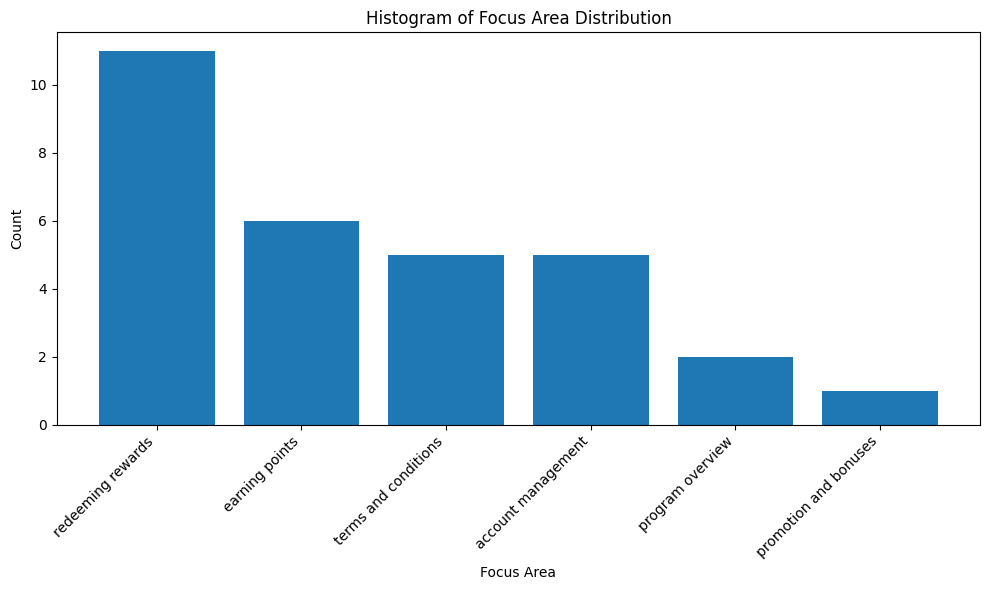

In [66]:
# prompt: histogram for focus_area distribution

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df_combined' is your DataFrame from the previous code.
# Replace with your actual DataFrame if it's named differently.

# Assuming your focus_area column is named 'focus_area'
# Change 'focus_area' to your column's actual name if necessary.
focus_area_counts = df_combined['focus_area'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(focus_area_counts.index, focus_area_counts.values)
plt.xlabel("Focus Area")
plt.ylabel("Count")
plt.title("Histogram of Focus Area Distribution")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


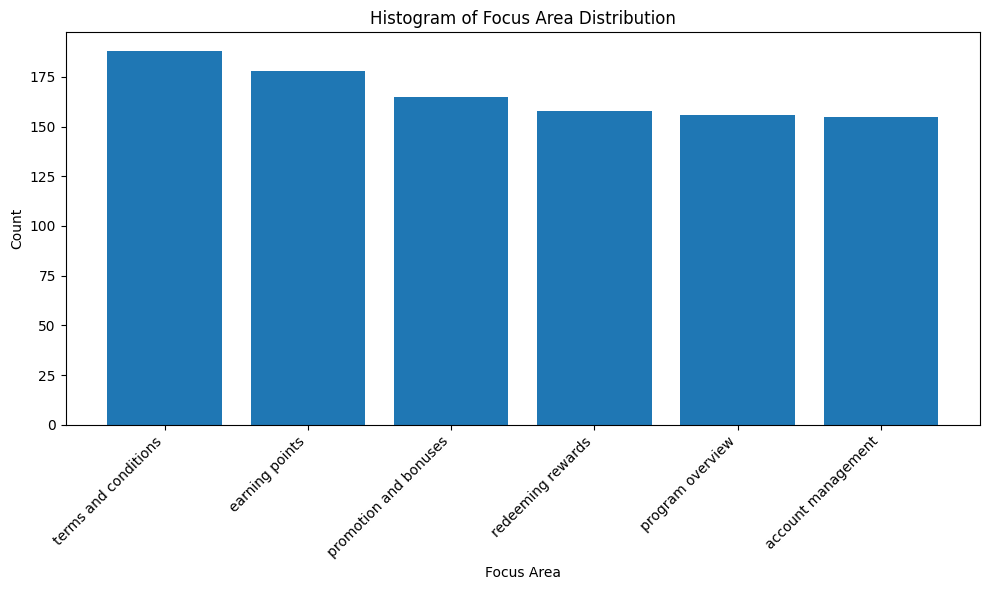

In [67]:
# prompt: histogram for focus_area distribution

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df_combined' is your DataFrame from the previous code.
# Replace with your actual DataFrame if it's named differently.

# Assuming your focus_area column is named 'focus_area'
# Change 'focus_area' to your column's actual name if necessary.
focus_area_counts = dataset['focus_area'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(focus_area_counts.index, focus_area_counts.values)
plt.xlabel("Focus Area")
plt.ylabel("Count")
plt.title("Histogram of Focus Area Distribution")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()
